# Sentiment Analytics on Restaurant Review

Tujuan dari analisis ini adalah untuk membuat model prediksi apakah ulasan restoran positif atau negatif. Dalam percobaan ini, saya menggunakan metode Long Short Term Memory (LSTM) untuk membuat model klasifikasi, dan saya mengamati penggunaan preprocessing untuk menghasilkan model terbaik.

Pada percobaan ini saya menggunakan Google Colabolatory untuk membuat model prediksi.

In [1]:
%tensorflow_version 1.15

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
!pip install pysastrawi

     |████████████████████████████████| 215kB 4.8MB/s 


## Load Data from Gitlab

In [0]:
!wget --quiet -P /content/Dataset https://gitlab.com/fahmisalman/sentiment-analytics/-/raw/master/Dataset/test_data_restaurant.tsv
!wget --quiet -P /content/Dataset https://gitlab.com/fahmisalman/sentiment-analytics/-/raw/master/Dataset/train_data_restaurant.tsv
!wget --quiet -P /content/Model https://gitlab.com/fahmisalman/sentiment-analytics/-/raw/master/Model/key_norm.csv
!wget --quiet -P /content/Model https://gitlab.com/fahmisalman/sentiment-analytics/-/raw/master/Model/stopword_list_TALA.txt

## Import Dependencies

In [0]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

In [0]:
df = pd.read_csv('Dataset/train_data_restaurant.tsv', sep='\t', header=None)
df.rename(columns={0: 'Text', 1: 'Sentimen'}, inplace=True)

In [6]:
df.head()

Text  Sentimen
0  Saya makan di sini dengan menggunakan voucher ...  negative
1  Mas indosat buat main game enemy has been slai...  negative
2  Trus sy percuma dong update no hp terbaru ke c...  negative
3  jika kita pilih dia maka akan ada lebih dari 3...  negative
4  Dikarenakan adik saya suka dengan restoran ini...  negative

## Data Exploratory

Langkah pertama adalah melakukan pengamatan data untuk mengamati karakteristik dari suatu data sebelum dilakukan proses lebih lanjut, sehingga bisa menentukan proses apa yang harus dilakukan dalam tahap *preprocessing*.

Dalam percobaan ini dilakukan pengamatan terhadap distribusi kelas, dan distribusi kata baik itu secara keseluruhan maupun per masing-masing kelas.

### Class disstribution

In [7]:
df['Sentimen'].value_counts()

positive    1200
negative     580
Name: Sentimen, dtype: int64

In [8]:
df['Sentimen'].value_counts().plot(kind='pie')

### Words distribution

In [9]:
df_explode = df['Text'].str.split().explode()
df_explode

0           Saya
0          makan
0             di
0           sini
0         dengan
          ...   
1779        baso
1779       tahu,
1779      sampai
1779          yg
1779    special.
Name: Text, Length: 68265, dtype: object

In [10]:
df_explode.value_counts()[:20]

dan        1856
yang       1592
di         1501
saya        869
dengan      830
untuk       673
tidak       650
makan       597
ini         584
makanan     525
juga        524
ada         504
yg          491
tempat      490
enak        439
nya         435
sangat      430
ke          405
cukup       402
dari        345
Name: Text, dtype: int64

In [11]:
df_explode.value_counts()[-20:]

booming         1
tersesat        1
memusingkan     1
driver          1
Muncul          1
carinya,        1
racikannya.     1
tubruk          1
bau,            1
sesuaidengan    1
"Ayam           1
long            1
subjektif)      1
(walaupun       1
hehe.,          1
truck           1
Cilakanya       1
karet.Selain    1
Ketakutan       1
kece            1
Name: Text, dtype: int64

In [12]:
df_explode.value_counts().shape

(12043,)

In [0]:
texts = ' '.join(df_explode)

In [14]:
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(texts)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Dari pengataman diatas dapat terlihat bahwa banyak tanda baca ataupun kata-kata yang mempunyai akar kata yang sama namun dianggap kata yang berbeda (contoh: "yg" dan "yang"), ada ketidakkonsistenan penulisan huruf kapital sehingga ada kata yang sama namun dianggap berbeda. Selain itu, kata-kata yang mempunyai frekuensi tertinggi merupakan kata-kata yang bisa digolongkan sebagai stopword dan akan dicoba juga penggunaan stemming untuk mengatasi masalah tersebut.


### Data Cleaning

Dari permasalahan diatas akan dilakukan proses sebagai berikut:

* text_lower: mengubah semua semua huruf kapital ke dalam huruf kecil
* text_cleaning: menghilangkan semua karakter kecuali karakter alfabet
* text_stemming: mengubah suatu kata ke dalam bentuk akarnya, pada percobaan ini algoritma yang digunakan adalah algoritma stemming [Nazief-Andriani](https://)
* stopwords_removal: menghilangkan semua kata yang terdapat di dalam stopwords, pada percobaan ini daftar stopword yang digunakan adalah daftar stopword hasil penelitian [(Tala et al., 2003)](https://pdfs.semanticscholar.org/8ed9/c7d54fd3f0b1ce3815b2eca82147b771ca8f.pdf)
* text_norm: mengubah kata singkatan menjadi kata asalnya. Daftar singkatan ini didapat dari https://www.kaggle.com/tiobagas/datasetsentimen#data_latih.json



In [0]:
def text_lower(texts):
    return texts.lower()

def text_cleaning(texts):
    return ' '.join((re.sub(r'[^a-z]', ' ', texts)).split())

def text_stemming(texts):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(texts)

def stopwords_removal(texts):
    texts_token = texts.split()
    not_stopword = []
    for token in texts_token:
        if token not in stopwords:
            not_stopword.append(token)
    return ' '.join(not_stopword)

def text_norm(texts):
    words = texts.split()
    for i in range(len(words)):
        try:
            words[i] = normwords.loc[words[i]]['hasil']
        except:
            pass
    return ' '.join(words)

In [0]:
def load_normwords(file):
    return pd.read_csv(file, index_col=['singkat'])

def load_stopwords(file):
    return [line.rstrip('\n\r') for line in open(file)]

In [0]:
def preprocessing(texts):
    tx_lower = text_lower(texts)
    tx_clean = text_cleaning(tx_lower)
    tx_norm = text_norm(tx_clean)
    return tx_norm

In [0]:
stopwords = load_stopwords("Model/stopword_list_TALA.txt")
normwords = load_normwords("Model/key_norm.csv")
global stopwords
global normwords

Ditambahkan beberapa kata ke dalam daftar stopword dan menghilangkan beberapa kata disesuaikan dengan kebutuhan untuk proses analisis sentimen

In [0]:
stopwords.extend(['nya'])
stopwords.remove('tidak')
stopwords.remove('enggak')
stopwords.remove('lama')

In [0]:
df_norm = df['Text'].apply(preprocessing)

In [21]:
df_norm

0       saya makan di sini dengan menggunakan voucher ...
1       mas indosat buat main game enemy has been sela...
2       terus saya percuma dong update nomor hp terbar...
3       jika kita pilih dia maka akan ada lebih dari k...
4       dikarenakan adik saya suka dengan restoran ini...
                              ...                        
1775    sangat suka minuman di sini selain merah meria...
1776    saat pertama saya melihat suasana di damai res...
1777    restoran yang terletak di kawasan intercontine...
1778    pilihan kaya baso dan lain-lain ny banyakk di ...
1779    menu utama adalah suki bedanya dengan resto su...
Name: Text, Length: 1780, dtype: object

In [22]:
df_norm.str.split().explode().value_counts()[:20]

yang       2135
dan        1950
di         1553
saya       1284
tidak      1146
dengan      921
enak        884
untuk       841
ini         759
makan       700
makanan     658
juga        637
tempat      624
ada         611
nya         545
sangat      470
menu        443
cukup       422
harga       414
ke          410
Name: Text, dtype: int64

In [23]:
df_norm.str.split().explode().value_counts().shape

(6519,)

In [24]:
df_explode = df_norm.str.split().explode()
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_explode))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
df_stem = df_norm.apply(text_stemming)

In [26]:
df_stem

0       saya makan di sini dengan guna voucher disdus ...
1       mas indosat buat main game enemy has been sela...
2       terus saya percuma dong update nomor hp baru k...
3       jika kita pilih dia maka akan ada lebih dari k...
4       karena adik saya suka dengan restoran ini saya...
                              ...                        
1775    sangat suka minum di sini selain merah riah ra...
1776    saat pertama saya lihat suasana di damai resto...
1777    restoran yang letak di kawasan intercontinenta...
1778    pilih kaya baso dan lain ny banyakk di sini ma...
1779    menu utama adalah suki beda dengan resto suki ...
Name: Text, Length: 1780, dtype: object

In [27]:
df_stem.str.split().explode().value_counts()[:20]

yang      2135
dan       1950
makan     1588
di        1553
saya      1285
tidak     1146
dengan     921
tempat     911
enak       904
untuk      841
ini        763
rasa       744
ada        715
juga       637
harga      603
nya        545
menu       501
sangat     470
sini       423
cukup      423
Name: Text, dtype: int64

In [28]:
df_stem.str.split().explode().value_counts().shape

(4863,)

In [29]:
df_explode = df_stem.str.split().explode()
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_explode))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
df_stop = df_stem.apply(stopwords_removal)

In [31]:
df_stop

0       makan voucher disdus paket nasi ayam kari disk...
1       mas indosat main game enemy has been susah ben...
2       update nomor hp cs cab bni data bni nomor hp l...
3                                     pilih kampung gusur
4       adik suka restoran mampir sih langsung tidak s...
                              ...                        
1775    suka minum merah riah enak manis pas aneka rag...
1776    lihat suasana damai resto ramai sambut rima sa...
1777    restoran letak kawasan intercontinental hotel ...
1778    pilih kaya baso ny banyakk macem unik suki bak...
1779    menu utama suki beda resto suki beli baso baso...
Name: Text, Length: 1780, dtype: object

In [32]:
df_stop.str.split().explode().value_counts()[:20]

makan       1588
tidak       1146
enak         904
harga        603
menu         501
bandung      398
layan        306
pilih        283
banget       282
ayam         282
goreng       273
restoran     258
jalan        249
pesan        241
coba         219
minum        209
nasi         207
nyaman       199
lumayan      198
mahal        190
Name: Text, dtype: int64

In [33]:
df_stop.str.split().explode().value_counts().shape

(4605,)

In [34]:
df_explode = df_stop.str.split().explode()
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_explode))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
df['Preprocessing'] = df_stop

In [36]:
df.Text.loc[0]

'Saya makan di sini dengan menggunakan voucher disdus. Paket nasi ayam kari, dengan diskon hingga 30 persen. Akibatnya para pengunjung mengantri untuk meredeem voucher. Cilakanya cek voucher masih dilakukan secara manual. Tidak ada masalah untuk makanannya, hanya saja antrian terlalu lama. Voucher sendiri sudah dibeli jadi mau tidak mau para pengunjung mengantri'

In [37]:
df.Preprocessing.loc[0]

'makan voucher disdus paket nasi ayam kari diskon persen akibat unjung antri meredeem voucher cilakanya cek voucher laku manual tidak makan antri lama voucher beli tidak unjung antri'

Dari kedua contoh diatas dapat terlihat bahwa setelah dilakukan *preprocessing* terdapat beberapa kata dan tanda baca yang hilang sehingga menghilangkan makna dari kalimat tersebut. Terlihat bahwa setelah penggunaan *preprocessing*, kalimat tersebut memiliki makna yang berbeda dibanding dengan kalimat awalnya, dikarenakan beberapa kata ada yang hilang, maupun berubah.

Dalam proses klasifikasi akan dibandingkan performansi dari penggunaan *preprocessing*.

### Words distribution for each class

#### Positive class

In [0]:
df_positive = df[(df['Sentimen'] == 'positive')]

In [39]:
df_positive.head()

Text  ...                                      Preprocessing
580  Jika makan dengan orang tua saya, saya selalu ...  ...  makan orang tua pilih aman selera orang tua ce...
581  Sierra cafe & lounge, resto ini menyediakan ma...  ...  sierra cafe lounge resto sedia makan masakan a...
582  Restauran yang menyajikan suasana tradisional ...  ...  restauran saji suasana tradisional padu suasan...
583  Restoran ini juga terletak di tempat stategis ...  ...  restoran letak stategis jalan dago belah hotel...
584  Rasa chocolatenya enak. Cuma bentuknya lucu-lu...  ...      chocolatenya enak bentuk lucu lucu gemas beli

[5 rows x 3 columns]

In [40]:
df_positive.shape

(1200, 3)

In [0]:
df_positive_explode = df_positive.Preprocessing.str.split().explode()

In [42]:
df_positive_explode.value_counts()[:20]

makan       1010
enak         710
tidak        493
harga        414
menu         373
bandung      328
pilih        223
ayam         223
goreng       207
banget       198
jalan        184
restoran     166
coba         160
suka         151
minum        150
nasi         148
nyaman       145
lumayan      143
porsi        137
layan        134
Name: Preprocessing, dtype: int64

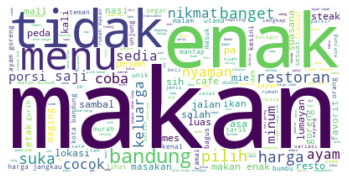

In [43]:
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_positive_explode))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Negative class

In [0]:
df_negative = df[(df['Sentimen'] == 'negative')]

In [45]:
df_negative.head()

Text  ...                                      Preprocessing
0  Saya makan di sini dengan menggunakan voucher ...  ...  makan voucher disdus paket nasi ayam kari disk...
1  Mas indosat buat main game enemy has been slai...  ...  mas indosat main game enemy has been susah ben...
2  Trus sy percuma dong update no hp terbaru ke c...  ...  update nomor hp cs cab bni data bni nomor hp l...
3  jika kita pilih dia maka akan ada lebih dari 3...  ...                                pilih kampung gusur
4  Dikarenakan adik saya suka dengan restoran ini...  ...  adik suka restoran mampir sih langsung tidak s...

[5 rows x 3 columns]

In [46]:
df_negative.shape

(580, 3)

In [0]:
df_negative_explode = df_negative.Preprocessing.str.split().explode()

In [48]:
df_negative_explode.value_counts()[:20]

tidak       653
makan       578
enak        194
harga       189
layan       172
pesan       147
menu        128
mahal       101
lama         96
restoran     92
jam          85
banget       84
kecewa       79
bandung      70
bagus        70
goreng       66
sih          66
jalan        65
nyata        63
lihat        61
Name: Preprocessing, dtype: int64

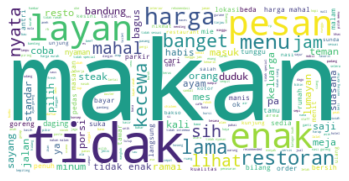

In [49]:
wc = WordCloud(max_font_size=1000, max_words=1000, background_color="white").generate(' '.join(df_negative_explode))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data Preparation

In [0]:
# convert class ['negative', 'positive'] into [0, 1]
y_train = np.array(list(df['Sentimen'].replace(['negative', 'positive'], [0, 1])))

In [51]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
num_words = 7000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_norm)

In [0]:
# Convert words into tokens
X_train_norm = tokenizer.texts_to_sequences(df_norm)

In [84]:
X_train_norm[0]

[4,
 10,
 3,
 40,
 6,
 574,
 1218,
 3181,
 396,
 48,
 36,
 851,
 6,
 852,
 414,
 3182,
 2292,
 525,
 231,
 682,
 8,
 3183,
 1218,
 3184,
 1219,
 1218,
 71,
 1838,
 270,
 3185,
 5,
 14,
 777,
 8,
 58,
 67,
 28,
 986,
 54,
 84,
 1218,
 225,
 31,
 2293,
 33,
 104,
 5,
 104,
 525,
 231,
 682]

In [85]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

sequence_to_text(X_train_norm[0])

['saya',
 'makan',
 'di',
 'sini',
 'dengan',
 'menggunakan',
 'voucher',
 'disdus',
 'paket',
 'nasi',
 'ayam',
 'kari',
 'dengan',
 'diskon',
 'hingga',
 'persen',
 'akibatnya',
 'para',
 'pengunjung',
 'mengantri',
 'untuk',
 'meredeem',
 'voucher',
 'cilakanya',
 'cek',
 'voucher',
 'masih',
 'dilakukan',
 'secara',
 'manual',
 'tidak',
 'ada',
 'masalah',
 'untuk',
 'makanannya',
 'hanya',
 'saja',
 'antrian',
 'terlalu',
 'lama',
 'voucher',
 'sendiri',
 'sudah',
 'dibeli',
 'jadi',
 'mau',
 'tidak',
 'mau',
 'para',
 'pengunjung',
 'mengantri']

In [86]:
print('Maximum review length: {}'.format(len(max(X_train_norm, key=len))))
print('Minimum review length: {}'.format(len(min(X_train_norm, key=len))))

Maximum review length: 83
Minimum review length: 8


Dari hasil diatas terlihat bahwa panjang maksimum dari token dalam data latih adalah 83 token, lalu diberi *padding* untuk menyamakan dimensi dari setiap kalimat dalam data latih.

Maksimal panjang token diatur sebanyak 100 untuk mengantisipasi jika ada data yang memiliki token lebih 83 di data uji.

Pada percobaan ini saya menggunakan *pre-padding* atau memberi angka 0 di depan kalimat, hal tersebut dikarenakan jika menggunakan *post-padding* akan ada banyak angka 0 di akhir *sequence* yang menyebabkan proses klasifikasi tidak maksimal.

In [0]:
X_train_norm_pad = pad_sequences(X_train_norm, maxlen=100, padding='pre', truncating='pre')

In [88]:
X_train_norm_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    4,   10,    3,   40,    6,  574,
       1218, 3181,  396,   48,   36,  851,    6,  852,  414, 3182, 2292,
        525,  231,  682,    8, 3183, 1218, 3184, 1219, 1218,   71, 1838,
        270, 3185,    5,   14,  777,    8,   58,   67,   28,  986,   54,
         84, 1218,  225,   31, 2293,   33,  104,    5,  104,  525,  231,
        682], dtype=int32)

## Classifier Construction

Dalam proses klasifikasi menggunakan metode Long Short Term Memory (LSTM) yang mempunyai 64 unit. Epoch yang digunakan adalah 10, dikarenakan setelah beberapa kali percobaan dilakukan, proses *training* sudah jenuh pada epoch tersebut.

In [0]:
def model_structure(max_token=100, embedding_size=256):
    model = Sequential()
    model.add(Embedding(input_dim=num_words,
                      output_dim=embedding_size,
                      input_length=max_token,
                      name='Embedding_layer'))
    model.add(LSTM(units=64, name='LSTM_layer'))
    model.add(Dense(1, activation='sigmoid', name='Output_layer'))
    model.compile(loss='mean_squared_error',
                optimizer=Adam(lr=1e-3),
                metrics=['accuracy'])
    return model

def model_summary(model):
    print(model.summary())

def model_fit(model, X, y, epoch=10):
    return model.fit(X, y, epochs=epoch)

In [0]:
def model_construction(X, y, num_words=7000, maxlen=100, embedding_size=256, epoch=10):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(X)
    X_train = tokenizer.texts_to_sequences(X)
    X_train_pad = pad_sequences(X_train, maxlen=maxlen, padding='pre', truncating='pre')
    model = model_structure(max_token=maxlen, embedding_size=embedding_size)
    model_summary(model)
    model_fit(model, X_train_pad, y, epoch=epoch)
    return model, tokenizer

In [92]:
model_norm, tokenizer_norm = model_construction(df_norm, y_train)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 100, 256)          1792000   
_________________________________________________________________
LSTM_layer_2 (LSTM)          (None, 64)                82176     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 65        
Total params: 1,874,241
Trainable params: 1,874,241
Non-trainable params: 0
_________________________________________________________________
None
Train on 1780 samples
Epoch 1/10
1780/1780 [==============================] - 8s 4ms/sample - loss: 0.1751 - acc: 0.7348
Epoch 2/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0555 - acc: 0.9354
Epoch 3/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0233 - acc: 0.9753
Epoch 4/10
1780/1780 [============================

In [0]:
with open('Model/tokenizer_norm.pickle', 'wb') as handle:
    pickle.dump(tokenizer_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)
model_norm.save('Model/model_norm.h5')

In [103]:
model_stem, tokenizer_stem = model_construction(df_stem, y_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 100, 256)          1792000   
_________________________________________________________________
LSTM_layer_2 (LSTM)          (None, 64)                82176     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 65        
Total params: 1,874,241
Trainable params: 1,874,241
Non-trainable params: 0
_________________________________________________________________
None
Train on 1780 samples
Epoch 1/10
1780/1780 [==============================] - 8s 4ms/sample - loss: 0.1780 - acc: 0.7287
Epoch 2/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0802 - acc: 0.9028
Epoch 3/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0370 - acc: 0.9562
Epoch 4/10
1780/1780 [============================

In [0]:
with open('Model/tokenizer_stem.pickle', 'wb') as handle:
    pickle.dump(tokenizer_stem, handle, protocol=pickle.HIGHEST_PROTOCOL)
model_stem.save('Model/model_stem.h5')

In [105]:
model_stop, tokenizer_stop = model_construction(df_stop, y_train)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 100, 256)          1792000   
_________________________________________________________________
LSTM_layer_2 (LSTM)          (None, 64)                82176     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 65        
Total params: 1,874,241
Trainable params: 1,874,241
Non-trainable params: 0
_________________________________________________________________
None
Train on 1780 samples
Epoch 1/10
1780/1780 [==============================] - 8s 4ms/sample - loss: 0.1820 - acc: 0.7331
Epoch 2/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0727 - acc: 0.9084
Epoch 3/10
1780/1780 [==============================] - 7s 4ms/sample - loss: 0.0339 - acc: 0.9596
Epoch 4/10
1780/1780 [============================

In [0]:
with open('Model/tokenizer_stop.pickle', 'wb') as handle:
    pickle.dump(tokenizer_stop, handle, protocol=pickle.HIGHEST_PROTOCOL)
model_stop.save('Model/model_stop.h5')

## Model Evaluate

In [0]:
df_test = pd.read_csv('Dataset/test_data_restaurant.tsv', sep='\t', header=None)
df_test.rename(columns={0: 'Text', 1: 'Sentimen'}, inplace=True)

In [108]:
df_test.head()

Text  Sentimen
0  Tempatnya sih menarik, mudah dijangkau dari se...  negative
1  lokasi strategis penasaran karena daerah situ ...  negative
2  Sesuai namanya, restoran ini unik dalam menyaj...  negative
3  Saya datang ketika petang dan hujan deras temp...  negative
4  Kalao mau ke sana jangan pas malem sih, soalny...  negative

In [109]:
df_test.shape

(185, 2)

In [0]:
df_test_norm = df_test['Text'].apply(preprocessing)
df_test_stem = df_test_norm.apply(text_stemming)
df_test_stop = df_test_stem.apply(stopwords_removal)

In [0]:
y_test = np.array(list(df_test['Sentimen'].replace(['negative', 'positive'], [0, 1])))

In [0]:
def model_score(X, y, model, tokenizer, max_len=100):
    X_test = tokenizer.texts_to_sequences(X)
    X_test_pad = pad_sequences(X_test, maxlen=100, padding='pre', truncating='pre')
    return model.evaluate(X_test_pad, y, verbose=0)

def model_predict(X, y, model, tokenizer, max_len=100):
    X_test = tokenizer.texts_to_sequences(X)
    X_test_pad = pad_sequences(X_test, maxlen=100, padding='pre', truncating='pre')
    return model.predict_classes(X_test_pad)

### Model1 Evaluation

In [113]:
model_score(df_test_norm, y_test, model_norm, tokenizer_norm)[1]

0.8216216

In [0]:
y_pred_norm = model_predict(df_test_norm, y_test, model_norm, tokenizer_norm)

In [115]:
confusion_matrix(y_test, y_pred_norm)

array([[ 40,  25],
       [  8, 112]])

In [127]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_norm).ravel()
(tn, fp, fn, tp)

(40, 25, 8, 112)

### Model2 Evaluation

In [116]:
model_score(df_test_stem, y_test, model_stem, tokenizer_stem)[1]

0.81621623

In [0]:
y_pred_stem = model_predict(df_test_stem, y_test, model_stem, tokenizer_stem)

In [118]:
confusion_matrix(y_test, y_pred_stem)

array([[ 37,  28],
       [  6, 114]])

In [128]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stem).ravel()
(tn, fp, fn, tp)

(37, 28, 6, 114)

### Model3 Evaluation

In [119]:
model_score(df_test_stop, y_test, model_stop, tokenizer_stop)[1]

0.72432435

In [0]:
y_pred_stop = model_predict(df_test_stop, y_test, model_stop, tokenizer_stop)

In [121]:
confusion_matrix(y_test, y_pred_stop)

array([[ 32,  33],
       [ 18, 102]])

In [129]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stop).ravel()
(tn, fp, fn, tp)

(32, 33, 18, 102)

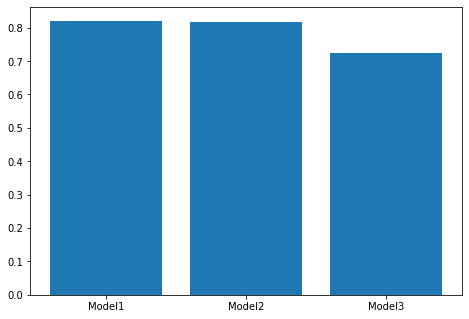

In [125]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
models = ['Model1', 'Model2', 'Model3']
scores = [model_score(df_test_norm, y_test, model_norm, tokenizer_norm)[1],
          model_score(df_test_stem, y_test, model_stem, tokenizer_stem)[1],
          model_score(df_test_stop, y_test, model_stop, tokenizer_stop)[1]]
ax.bar(models, scores)
plt.show()

## Conclusion

Dari percobaan yang telah dilakukan dapat disimpulkan bahwa model tanpa menggunakan *stemming* dan *stopword removal* menghasilkan hasil yang terbaik, yaitu akurasi sebesar 82,16%. Sementara model yang menggunakan *stemming* dan *stopword removal* mempunyai nilai akurasi terkecil, yaitu 72,43%. Hal ini terjadi karena banyaknya kata-kata yang hilang dikarenakan merupakan kata-kata yang terdapat di dalam daftar stopword. Selain itu, model yang digunakan dalam percobaan ini yaitu LSTM, bekerja dengan melihat pola dalam kalimat, berbeda dengan metode *machine learning* pada umumnya yang menghitung statistik antar kata, sehingga model1 dan model2 mendapatkan hasil yang lebih baik dari model3, walaupun model1 sedikit lebih baik dari model2, karena model2 beberapa kata memiliki perbedaan makna karena proses stemming.

Selain itu, di semua model mempunyai kasus false positif lebih banyak dari false negatif. Hal ini terjadi dikarenakan jumlah kelas *positive* di data latih jauh lebih besar dibandingkan kelas *negative*, sehingga menyebabkan probabilitas model untuk mengklasifikasikan suatu kalimat ke dalam kelas *positive* jauh lebih besar dari kelas *negative*.